<a href="https://colab.research.google.com/github/Zypher44/RaduIntuneric/blob/master/Skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building a an NLP model to make reading medical abstract easier 

In [1]:
!nvidia-smi

Tue Aug  3 23:29:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

--2021-08-03 23:29:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-03 23:29:27 (57.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import *

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
#Check the data set with 20k 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [6]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [7]:
#Check all filenames in target directory 
import os 
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

#Preprocessing data


In [8]:
#Create function to read lines of doucment 

def get_lines(filename):
  """
  Reads Filename (a text filename) and returns line of text as a list 
  Args: Filename : a string contraining the target filename
  Returns a list of string with open string per line
  """

  with open(filename,"r") as f:
    return f.readlines()


In [9]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
type(train_lines)

list

In [11]:
len(train_lines)

210040

In [12]:
def convert(a):
  """
  Convert list to dic 
  """
  it = iter(a)
  res_dct = dict(zip(it,it))
  return res_dct

In [13]:
converted = convert(train_lines)
type(converted)

dict

In [14]:
def preprocessed_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_line"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [15]:
#Get data from file and preprocess it 

train_samples = preprocessed_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocessed_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocessed_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [16]:
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_line': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_line': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_line': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_line': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures included th

In [17]:
test_samples[:10]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'total_line': 8},
 {'line_number': 1,
  'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'total_line': 8},
 {'line_number': 2,
  'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'total_line': 8},
 {'line_number': 3,
  'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate

In [18]:
val_samples[:10]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'total_line': 9},
 {'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'it is not clear whether these patients would benefit from antifungal treatment .',
  'total_line': 9},
 {'line_number': 2,
  'target': 'OBJECTIVE',
  'text': 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
  'total_line': 9},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'total_line': 9},
 {'line_numb

In [19]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [20]:
train_df[:14]

,target,text,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [21]:
#Distriubtion of labels 
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

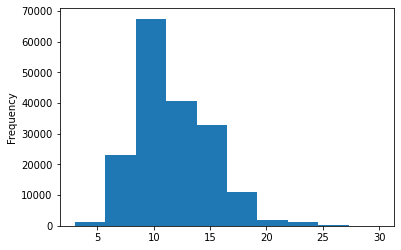

In [22]:
#Check length of differnet lines 
train_df.total_line.plot.hist()

#Get list of sentences 


In [23]:
#Convert abstract text lines into lists

train_senteces= train_df['text'].to_list()
val_senteces = val_df['text'].to_list()
test_senteces = test_df['text'].to_list()

In [24]:
len(train_senteces), len(val_senteces), len(test_senteces)

(180040, 30212, 30135)

In [25]:
train_senteces[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [26]:
#Make labels numeric One hot encode

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

#Label encode labels 

In [27]:
#Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [28]:
#Get class names and number of classes from LabelEncoder instances 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#baseline model 

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

baseline = Pipeline([
      ('tfidf', TfidfVectorizer()),
      ("clf", MultinomialNB())
])


In [30]:
baseline.fit(train_senteces,train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [31]:
baseline_score = baseline.score(val_senteces,val_labels_encoded)

In [32]:
baseline_score

0.7218323844829869

In [33]:
#Make perdicitons using baseline model 

baseline_preds = baseline.predict(val_senteces)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [34]:
baseline_results = calculate_results(y_pred=baseline_preds,y_true=val_labels_encoded)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

#Tokenize text and embed them (train sentences) and build a Conv1d model 


In [35]:
#tokenizeing the data with TextVectorization 
import tensorflow as tf


In [36]:
max_len= round(sum([len(i.split()) for i in train_senteces])/len(train_senteces))
max_len

26

In [37]:
max_features = 68000 #Maxium vocab size 


text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_features,
    standardize="lower_and_strip_punctuation",
    output_mode='int',
    output_sequence_length=55, #Could be 55 

)

In [38]:
text_vectorizer.adapt(train_senteces)

In [39]:
words_in_data= text_vectorizer.get_vocabulary()

In [40]:
top5_words_in_data= words_in_data[:5]
bottm5_words_in_data = words_in_data[-5:]

In [41]:
top5_words_in_data

['', '[UNK]', 'the', 'and', 'of']

In [42]:
bottm5_words_in_data

['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']

In [43]:
from tensorflow.keras import layers 

embedding = layers.Embedding(input_dim=max_features,
                             output_dim=128,
                             input_length=max_len)

In [44]:
Save_dir = "Model_logs"

In [45]:
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

In [46]:
#Creating datasets (making sure our data is as efficently as possible)
#Turn our data into Tensorflow datasets 

train_dataset = tf.data.Dataset.from_tensor_slices((train_senteces,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_senteces,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_senteces,test_labels_one_hot))

In [47]:
#Take Tensorsliced data and turn them into prefetch data, makes dataset more efficent 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [48]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [49]:
valid_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

#Build a Conv1d model 

In [50]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(text_vectorizer)
model.add(embedding)
model.add(tf.keras.layers.Conv1D(32,5,activation='relu'))
model.add(tf.keras.layers.Conv1D(32,5,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Flatten())
model.add(layers.Dense(5,activation='sigmoid'))

In [51]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_dataset,
    steps_per_epoch = int(0.1*len(train_dataset)),
    validation_data=valid_dataset,
    epochs=3,
    validation_steps= int(0.1*len(valid_dataset))

)

Epoch 1/3
562/562 [==============================] - 81s 88ms/step - loss: 0.9112 - accuracy: 0.6335 - val_loss: 0.7461 - val_accuracy: 0.7576
Epoch 2/3
562/562 [==============================] - 49s 87ms/step - loss: 0.6486 - accuracy: 0.7561 - val_loss: 0.7083 - val_accuracy: 0.7650
Epoch 3/3
562/562 [==============================] - 49s 87ms/step - loss: 0.6098 - accuracy: 0.7756 - val_loss: 0.6676 - val_accuracy: 0.7872


In [53]:
model.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6729 - accuracy: 0.7861


[0.6728688478469849, 0.7861114740371704]

In [54]:
model_pred_probs = model.predict(valid_dataset)
model_pred_probs.shape

(30212, 5)

In [55]:
model_preds = tf.argmax(model_pred_probs, axis=1)
model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 1, 1])>

In [56]:
model_results = calculate_results(val_labels_encoded,model_preds)
model_results

{'accuracy': 78.61114788825633,
 'f1': 0.7852835656852891,
 'precision': 0.7891498672045306,
 'recall': 0.7861114788825633}

In [57]:
baseline_score

0.7218323844829869

In [58]:
#Tensorflow pretrained embeddings (find out what pretrained embeddings they used from the papers, check tensorflow hub) (USE)

In [59]:
import tensorflow_hub as hub 

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [60]:
embeddings= embed(["The Cat with the gat"])
embeddings[:1]

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 2.37003323e-02, -9.71480925e-03,  1.10328821e-02,
         5.40320808e-03,  3.31264138e-02, -4.82648984e-02,
        -9.34601799e-02,  7.42588490e-02,  7.64714852e-02,
         4.07842509e-02,  5.48631065e-02,  8.43737498e-02,
        -5.55536076e-02, -2.24567689e-02,  7.52587570e-03,
        -6.75101355e-02, -1.69797186e-02,  5.23934141e-02,
         1.34974355e-02, -3.86228710e-02, -1.69085264e-02,
         5.77974315e-05, -1.26626790e-02,  2.03139056e-02,
        -3.06255557e-02, -2.47146804e-02, -3.13062146e-02,
        -2.29332875e-02, -1.07233447e-03, -2.33081114e-02,
         3.61425499e-03, -2.50756834e-02,  2.22472735e-02,
        -6.31046146e-02, -1.20391501e-02,  4.77865785e-02,
        -7.55551644e-03, -2.66807707e-04, -1.51971704e-03,
        -2.26910226e-02,  2.73353830e-02, -2.54034810e-02,
        -1.03102019e-02, -5.17009199e-02, -9.76150334e-02,
         2.91569419e-02,  2.71003204e-03, -5.59290461e-02,
      

Model2 Universal sentence encoder 

In [61]:
sentence_encoder = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    
    name="USE"
)

In [62]:
model2 = tf.keras.Sequential([
   sentence_encoder,
   layers.Dense(64,activation='relu'),
   layers.Dense(64,activation='relu'),
   layers.Dense(len(class_names),activation='softmax')
])

In [63]:
model2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),#Working with multiclass
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [64]:
valid_dataset, train_dataset

(<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>,
 <PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>)

In [65]:
model2.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    validation_data=(valid_dataset),
    validation_steps=(int(0.1*len(valid_dataset))),
    epochs=3
)

Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9182 - accuracy: 0.6341 - val_loss: 0.8002 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7567 - accuracy: 0.7057 - val_loss: 0.7373 - val_accuracy: 0.7141
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7310 - accuracy: 0.7188 - val_loss: 0.7066 - val_accuracy: 0.7287


In [66]:
model2.evaluate(valid_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7149 - accuracy: 0.7245


[0.7149113416671753, 0.7244803309440613]

In [67]:
model2_pred_probs = model2.predict(valid_dataset)
model2_pred_probs

array([[4.8573458e-01, 2.7365974e-01, 3.0886536e-03, 2.3133203e-01,
        6.1849286e-03],
       [4.1335317e-01, 4.3631509e-01, 3.8133275e-03, 1.4385240e-01,
        2.6660089e-03],
       [2.5311667e-01, 6.9812119e-02, 1.9285887e-02, 6.4361793e-01,
        1.4167420e-02],
       ...,
       [1.0095540e-03, 5.4035606e-03, 6.1728403e-02, 5.4708601e-04,
        9.3131143e-01],
       [3.4584552e-03, 3.7567068e-02, 2.6566550e-01, 1.1936483e-03,
        6.9211531e-01],
       [3.0832916e-01, 3.9215720e-01, 2.2885959e-01, 1.6516706e-02,
        5.4137304e-02]], dtype=float32)

In [68]:
model2_preds = tf.argmax(model2_pred_probs, axis=1)
model2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [69]:
model2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model2_preds)
model2_results

{'accuracy': 72.44803389381703,
 'f1': 0.7234784542658288,
 'precision': 0.726156165709903,
 'recall': 0.7244803389381702}

In [70]:
model_results

{'accuracy': 78.61114788825633,
 'f1': 0.7852835656852891,
 'precision': 0.7891498672045306,
 'recall': 0.7861114788825633}

In [71]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

#Model3 : Conv1d with character embeddings 

In [72]:
#Create a character level tokenizer map every character in the seqence 
train_senteces[:5]



['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [73]:
#Make a function to split sentences into characters 

def split_chars(text):
  return " ".join(list(text))

In [74]:
split_chars(train_senteces[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [75]:
#Split seqence-level data splits into character level data splits 

train_chars = [split_chars(sentence) for sentence in train_senteces]
val_chars = [split_chars(sentence) for sentence in val_senteces]
test_chars = [split_chars(sentence) for sentence in test_senteces]

In [76]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [77]:
#Find the average character length !

chars_lens = [len(sentence) for sentence in train_senteces]
mean_char_lens= np.mean(chars_lens)
mean_char_lens

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

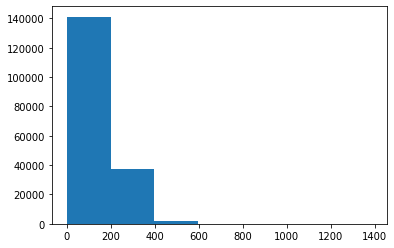

In [78]:
#Check the distribution of our sequences at a character level 
import matplotlib.pyplot as plt

plt.hist(chars_lens,bins=7)

In [79]:
#Find what character length cover 95% of sequences 
output_seq_char_len = int(np.percentile(chars_lens,95))
output_seq_char_len

290

In [80]:
#Get all keyboard characters 
import string 

alphabet = string.ascii_lowercase + string.digits + string.punctuation 
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [81]:
len(alphabet)

68

In [82]:
#Create char level token vectorizer instance 
NUM_char_tokens = len(alphabet) + 2 #add 2 for space and OOV token(OOV= Out of Vocab)
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=NUM_char_tokens,
    output_sequence_length=output_seq_char_len, #How long should output sequence be?
    standardize="lower_and_strip_punctuation",
    name="Char_Vectorizer"
    )

In [83]:
#Adapt character vectorizer to training vectorizer 

char_vectorizer.adapt(train_chars)

In [84]:
#Check character vocab 
char_vocab = char_vectorizer.get_vocabulary()
top_5_char = char_vocab[:5]
bottom_5_char = char_vocab[-5:]

In [85]:
top_5_char

['', '[UNK]', 'e', 't', 'i']

In [86]:
bottom_5_char

['k', 'x', 'z', 'q', 'j']

In [87]:
len(char_vocab)

28

In [88]:
sentence=["the cat with the gat "]

print(char_vectorizer([sentence]))

tf.Tensor(
[[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]], shape=(1, 290), dtype=int64)


In [89]:
char_embed = layers.Embedding(
    input_dim = len(char_vocab),#Number of different characters
    output_dim = 25, 
    mask_zero = True,
    name="char_embed"
)

In [90]:
# 
print(f"the gat with the gat")
print(char_embed(char_vectorizer(['the gat with the cat'])))

the gat with the gat
tf.Tensor(
[[[-0.04051211 -0.04090754 -0.04349594 ...  0.00118726 -0.01078971
    0.01346222]
  [-0.04051211 -0.04090754 -0.04349594 ...  0.00118726 -0.01078971
    0.01346222]
  [-0.04051211 -0.04090754 -0.04349594 ...  0.00118726 -0.01078971
    0.01346222]
  ...
  [ 0.04487041 -0.03325199 -0.01921471 ...  0.04324626  0.04750248
    0.04328556]
  [ 0.04487041 -0.03325199 -0.01921471 ...  0.04324626  0.04750248
    0.04328556]
  [ 0.04487041 -0.03325199 -0.01921471 ...  0.04324626  0.04750248
    0.04328556]]], shape=(1, 290, 25), dtype=float32)


In [91]:
#Build a Conv1d model with char embeddings and char vectorizer 

model3 =  tf.keras.Sequential()
model3.add(tf.keras.Input(shape=(1,),dtype=tf.string))
model3.add(char_vectorizer)
model3.add(char_embed)
model3.add(layers.Conv1D(64,5,activation='relu'))
model3.add(layers.Conv1D(64,5,activation='relu'))
model3.add(layers.Dropout(0.1))
model3.add(layers.GlobalMaxPool1D())
model3.add(layers.Flatten())
model3.add(layers.Dense(len(class_names), activation='softmax'))


In [92]:
model3.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [93]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Char_Vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 286, 64)           8064      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 282, 64)           20544     
_________________________________________________________________
dropout_1 (Dropout)          (None, 282, 64)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [94]:
#Create char level datasets 
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [95]:
val_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [96]:
history3 = model3.fit(
    train_char_dataset,
    steps_per_epoch = int(0.1*len(train_char_dataset)),
    validation_data=val_char_dataset,
    epochs=3,
    validation_steps= int(0.1*len(val_char_dataset))

)

Epoch 1/3
562/562 [==============================] - 6s 9ms/step - loss: 1.2142 - accuracy: 0.4958 - val_loss: 1.0016 - val_accuracy: 0.5914
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9710 - accuracy: 0.6043 - val_loss: 0.8893 - val_accuracy: 0.6499
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.8919 - accuracy: 0.6462 - val_loss: 0.8235 - val_accuracy: 0.6835


In [97]:
model3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8334 - accuracy: 0.6763


[0.833445131778717, 0.6763206720352173]

In [98]:
model3_pred_probs = model3.predict(val_char_dataset)

In [99]:
model3_pred_probs

array([[0.31387103, 0.27726117, 0.08479687, 0.28594834, 0.0381226 ],
       [0.19220646, 0.3534167 , 0.0196281 , 0.3663217 , 0.06842706],
       [0.14297643, 0.18297096, 0.03741986, 0.602796  , 0.0338367 ],
       ...,
       [0.00632532, 0.03022598, 0.03662956, 0.00830674, 0.91851234],
       [0.01943035, 0.20190805, 0.22596127, 0.02263646, 0.53006387],
       [0.6615614 , 0.16367263, 0.06121676, 0.10523749, 0.00831171]],
      dtype=float32)

In [100]:
#Convert perdiciton probaiblies to class labels 
model3_preds = tf.argmax(model3_pred_probs,axis=1) #Tf.argmax gets the maxium index value 

In [101]:
model3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 3, 3, ..., 4, 4, 0])>

In [102]:
model3_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model3_preds)
model3_results, model_results, model2_results, baseline_results

({'accuracy': 67.63206672845227,
  'f1': 0.6705830090102662,
  'precision': 0.673426824866311,
  'recall': 0.6763206672845227},
 {'accuracy': 78.61114788825633,
  'f1': 0.7852835656852891,
  'precision': 0.7891498672045306,
  'recall': 0.7861114788825633},
 {'accuracy': 72.44803389381703,
  'f1': 0.7234784542658288,
  'precision': 0.726156165709903,
  'recall': 0.7244803389381702},
 {'accuracy': 72.1832384482987,
  'f1': 0.6989250353450294,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869})

#Combine Tensorflow hub token embeddings + character embeddings 


#Multimodel model

1. Create a token-level embeeding model (similar to 'model 1')
2. Create a character level model (similar to 'model3' with a slight modifictication)
3. Combine both these models with a concatentate ('layers.Concatenate')
4. Build a series of output layers on top of 3 similar figures of bidirectional LSTM, dropout 0.5 before label perdiciton layer, use Stochastic Gradident decsent optimizer instead of Adam
5. Construct a model that takes token-level and character level embedding as inputs and produces sequence label probabilites as outputs 


In [103]:
embed

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f8a300b4b10>

In [104]:
 #Setup token inputs/model step 1 
 token_inputs = layers.Input(shape=[],dtype=tf.string)
 token_embeddings= sentence_encoder(token_inputs)
 token_output = layers.Dense(128,activation='relu')(token_embeddings)
 token_model= tf.keras.Model(token_inputs, token_output)
 token_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
Total params: 256,863,488
Trainable params: 65,664
Non-trainable params: 256,797,824
_________________________________________________________________


In [105]:
#Create a character level model char inputs /model
char_inputs = layers.Input(shape=[1,],dtype=tf.string)
char_vectorizing = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectorizing)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_output = layers.Dense(128, activation='relu')(char_bi_lstm)
char_model = tf.keras.Model(char_inputs, char_output)
char_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
Char_Vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
bidirectional (Bidirectional (None, 48)                9600      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               6272      
Total params: 16,572
Trainable params: 16,572
Non-trainable params: 0
_________________________________________________________________


In [106]:

#3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="Token_char_hybrid")([token_model.output,
                                                                  char_model.output])

In [107]:
#4. Create output layers adding in dropout 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

In [108]:
#Construct model with char and token inputs 

model4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                        outputs=output_layer)

In [109]:
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
Char_Vectorizer (TextVectorizat (None, 290)          0           input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, 290, 25)      700         Char_Vectorizer[1][0]            
____________________________________________________________________________________________

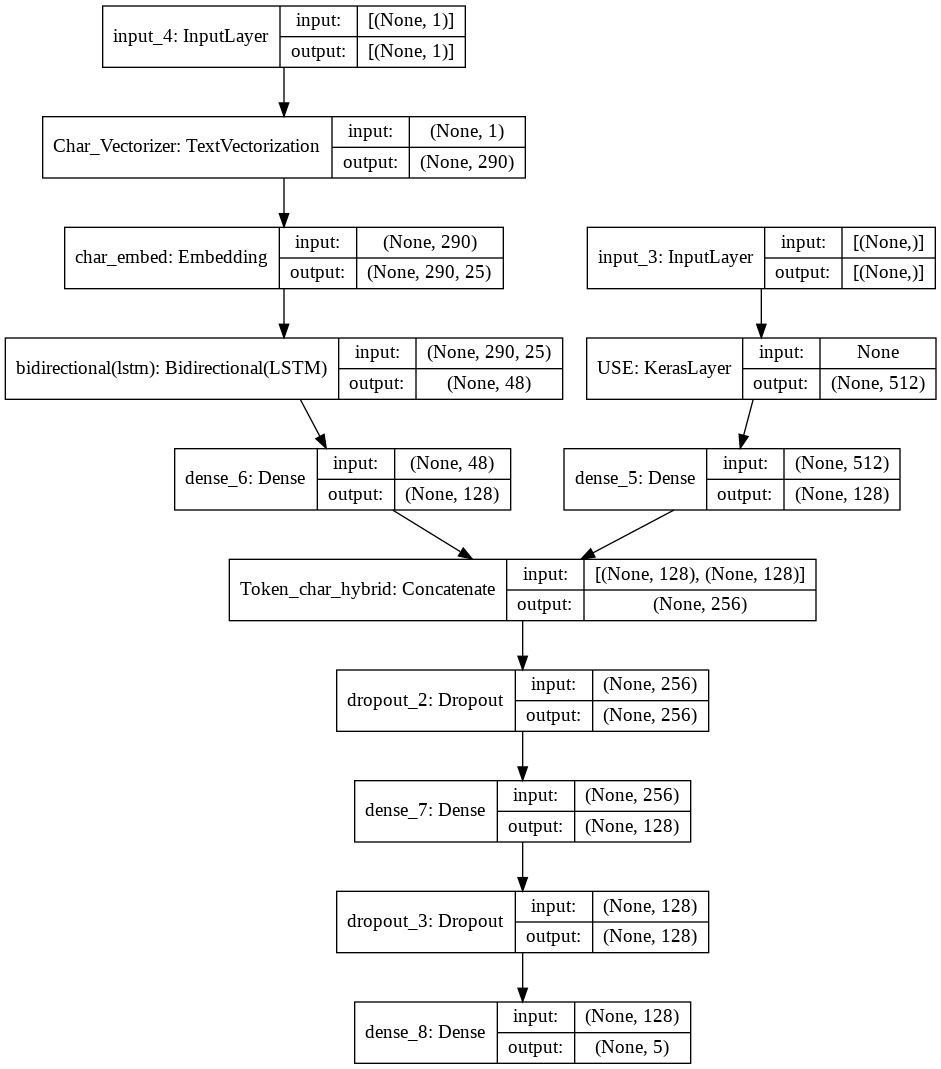

In [110]:
#Plot hybrid token and Char model 
tf.keras.utils.plot_model(model4,show_shapes=True)

In [111]:
#Compile token char model 
model4.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics= ['accuracy']
)

#Combining token and character data into a tf.data Dataset 

In [112]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_senteces, train_chars)) #Make data, make sure order the same as model 
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #Make labels 
train_char_token_Dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

#Prefetch and abtch train dataset
train_char_token_Dataset =  train_char_token_Dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [113]:
train_char_token_Dataset

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

In [114]:
#Do the same to valudation data 

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_senteces,val_chars))#Make data 
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) #Make labels 
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [115]:
val_char_token_dataset

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

In [116]:
history4 = model4.fit(
    train_char_token_Dataset,
    epochs=3,
    validation_data=val_char_token_dataset,
    steps_per_epoch=int(0.1*len(train_char_token_Dataset)),
    validation_steps=int(0.1*len(val_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 37s 51ms/step - loss: 0.9846 - accuracy: 0.6072 - val_loss: 0.7731 - val_accuracy: 0.7028
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.7938 - accuracy: 0.6971 - val_loss: 0.7075 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7641 - accuracy: 0.7051 - val_loss: 0.6830 - val_accuracy: 0.7424


In [117]:
model4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.6962 - accuracy: 0.7353


[0.6961904168128967, 0.73533695936203]

In [118]:
model4_pred_probs = model4.predict(val_char_token_dataset)

In [119]:
model4_pred_probs

array([[4.7594863e-01, 2.7874869e-01, 4.7877044e-03, 2.3262723e-01,
        7.8876652e-03],
       [3.4519288e-01, 5.2159691e-01, 3.9226389e-03, 1.2737413e-01,
        1.9133749e-03],
       [3.3251810e-01, 1.7566389e-01, 4.9527362e-02, 4.0820408e-01,
        3.4086499e-02],
       ...,
       [4.7638724e-04, 9.0297852e-03, 7.8250907e-02, 2.6255101e-04,
        9.1198039e-01],
       [5.2701109e-03, 4.3134477e-02, 3.2504624e-01, 3.1315654e-03,
        6.2341762e-01],
       [2.5562364e-01, 3.7237725e-01, 3.1549659e-01, 2.3002168e-02,
        3.3500325e-02]], dtype=float32)

In [120]:
model4_preds = tf.argmax(model4_pred_probs, axis=1)

In [121]:
model4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [122]:
model4_results = calculate_results(y_pred=model4_preds,
                                   y_true=val_labels_encoded)
model4_results

{'accuracy': 73.53369522044221,
 'f1': 0.7346263037819885,
 'precision': 0.7374506801480654,
 'recall': 0.7353369522044221}

 #Model 5 Transfer  learning with pretrained token embeddings + character embeddings + postional emeddings 

In [123]:
train_df.head()

,target,text,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


  #Create postitonal embeddings

In [124]:
#how many differne tline numbers are there 
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

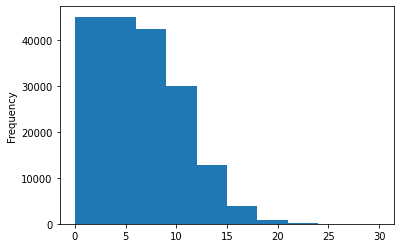

In [125]:
train_df.line_number.plot.hist()

In [126]:
#Use tensorflow to one hot encoded the line numbers 

train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [127]:
 train_df.head()

,target,text,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [128]:
train_df['total_line'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_line, dtype: int64

In [129]:
train_total_line_one_hot = tf.one_hot(train_df['total_line'].to_numpy(),depth=20)
val_total_line_one_hot = tf.one_hot(val_df['total_line'].to_numpy(),depth=20)
test_total_line_one_hot= tf.one_hot(test_df['total_line'].to_numpy(),depth=20)

In [130]:
np.percentile(train_df.total_line,95)

18.0

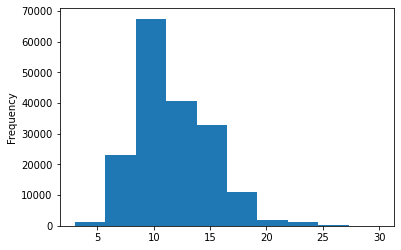

In [131]:
train_df.total_line.plot.hist()

In [132]:
train_total_line_one_hot[:10], train_total_line_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

#Building a tribrid embedding model 

1. Create a token-level model 
2. Create a character level model 
3. Create a model for the 'line number feature'
4. Create a model for the 'total line feature'
5. Combine the outputs of 1, and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribreied ambedding and output label probabilites
8. Combine the inputs of 1,2,3,4 and the outputs of 7 into a tf.keras.Model


In [133]:
#Create token inputs 

token_inputs = layers.Input(shape=[],dtype=tf.string)
token_embeddings= sentence_encoder(token_inputs)
x= layers.Dense(64, activation='relu')(token_embeddings)
token_output = layers.Dense(num_classes, activation='softmax')(x)

token_model = tf.keras.Model(token_inputs,token_output)

In [134]:
token_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_9 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 325       
Total params: 256,830,981
Trainable params: 33,157
Non-trainable params: 256,797,824
_________________________________________________________________


In [135]:
char_inputs = layers.Input(shape=(1,),dtype=tf.string)
x = char_vectorizer(char_inputs)
x = char_embed(x)
x = layers.Dense(64,activation='relu')(x)
x_bi_lstm = layers.Bidirectional(layers.LSTM(24), name='bi')(x)
char_output= layers.Dense(num_classes, activation='softmax')(x_bi_lstm)
char_model1 = tf.keras.Model(char_inputs,char_output)

In [136]:
char_model1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
Char_Vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
dense_11 (Dense)             (None, 290, 64)           1664      
_________________________________________________________________
bi (Bidirectional)           (None, 48)                17088     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 245       
Total params: 19,697
Trainable params: 19,697
Non-trainable params: 0
_______________________________________________________

In [137]:
#Create a model for the line numbers model inputs, shape =?, dnese layer with 32 units, relu, Combine inputs and dense layer into mode
train_line_numbers_one_hot.shape

TensorShape([180040, 15])

In [138]:
train_line_numbers_one_hot.dtype

tf.float32

In [139]:
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [140]:
#Create a model for Line Numbers model 

line_numbers_input = layers.Input(shape=(15,),dtype=tf.float32)
x = layers.Dense(32,activation='relu')(line_numbers_input)

line_number_model = tf.keras.Model(line_numbers_input,x)
line_number_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                512       
Total params: 512
Trainable params: 512
Non-trainable params: 0
_________________________________________________________________


In [141]:
#Create a model for total lines 
train_total_line_one_hot.shape

TensorShape([180040, 20])

In [142]:
train_total_line_one_hot.dtype

tf.float32

In [143]:
total_line_input = layers.Input(shape=(20,),dtype=tf.float32)
x = layers.Dense(64,activation='relu')(total_line_input)
total_line_Model= tf.keras.Model(total_line_input,
                                 x)

In [144]:
total_line_Model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                1344      
Total params: 1,344
Trainable params: 1,344
Non-trainable params: 0
_________________________________________________________________


In [145]:
#Combine token and char embeddings into a hybrib embedding 

combined_embeddigngs = layers.Concatenate(name='char_token_hybrib_embedinngs')([token_model.output,
                                                                                 char_model1.output])

In [146]:
token_model.output

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_10')>

In [147]:
char_model1.output

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_12')>

In [148]:
z = layers.Dense(256, activation='relu')(combined_embeddigngs)
z = layers.Dropout(0.5)(z)


In [149]:
#Combine positial embedding with combinined token and char embeddings 
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                 total_line_Model.output,
                                                                                 z])

In [150]:
# 7 Create output layer
output_layer= layers.Dense(num_classes,activation='softmax',name='output_layer')(tribrid_embeddings)

In [151]:
#8 put together model with all kinds of inputs 
model_5 = tf.keras.Model([line_number_model.input, 
                          total_line_Model.input,
                          token_model.input,
                          char_model1.input],
                         outputs=output_layer,
                         name='tribred_embedding_model5')

In [152]:
model_5.summary()

Model: "tribred_embedding_model5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
Char_Vectorizer (TextVectorizat (None, 290)          0           input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, 290, 25)      700         Char_Vectorizer[2][0]            
___________________________________________________________________________

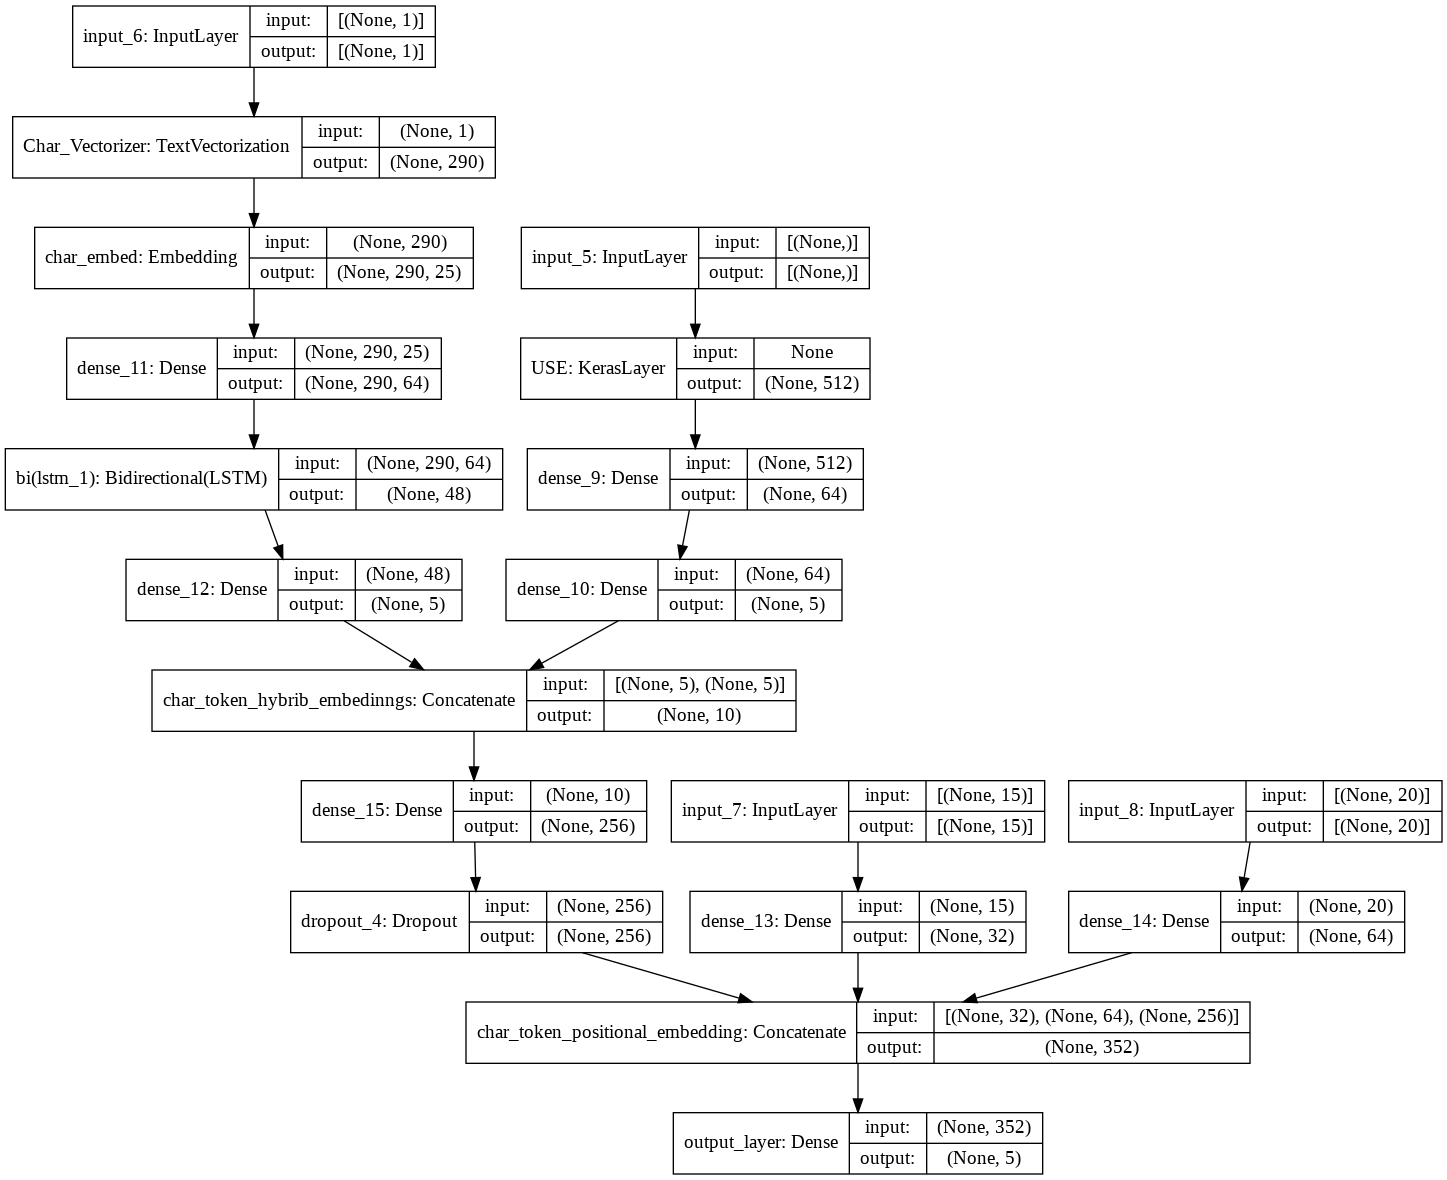

In [153]:
#Plot model _5 arcitecture 
tf.keras.utils.plot_model(model_5,show_shapes=True)

In [154]:
#Compile token,char,and positioanl embedinng model 
model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), #helps prevent overfitting
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [155]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_line_one_hot,
                                                                train_senteces,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_Dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))

train_char_token_pos_Dataset = train_char_token_pos_Dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [156]:
# Make validation data 

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_line_one_hot,
                                                              val_senteces,
                                                              val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_Dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))

val_char_token_pos_Dataset = val_char_token_pos_Dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [157]:
val_char_token_pos_Dataset , train_char_token_pos_Dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [160]:
model_5.fit(
    train_char_token_pos_Dataset,
    epochs=3,
    steps_per_epoch = int(0.5*len(train_char_token_pos_Dataset)),
    validation_data=val_char_token_pos_Dataset,
)

Epoch 1/3
2813/2813 [==============================] - 153s 55ms/step - loss: 0.9835 - accuracy: 0.7963 - val_loss: 0.9389 - val_accuracy: 0.8288
Epoch 2/3
2813/2813 [==============================] - 156s 55ms/step - loss: 0.9416 - accuracy: 0.8298 - val_loss: 0.9209 - val_accuracy: 0.8389
Epoch 3/3
   1/2813 [..............................] - ETA: 1:27 - loss: 0.9826 - accuracy: 0.8750WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 8439 batches). You may need to use the repeat() function when building your dataset.


2813/2813 [==============================] - 19s 7ms/step - loss: 0.9826 - accuracy: 0.8750 - val_loss: 0.9206 - val_accuracy: 0.8396


In [161]:
model_5_predProbs = model_5.predict(val_char_token_pos_Dataset)

In [162]:
model_5_pred = tf.argmax(model_5_predProbs,axis=1)


In [163]:
#Calculate results 

model5_results = calculate_results(val_labels_encoded,
                                   model_5_pred)

In [164]:
model5_results

{'accuracy': 83.95670594465776,
 'f1': 0.8364992459493259,
 'precision': 0.8416877086832159,
 'recall': 0.8395670594465775}

In [165]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

#Save and load the model 

In [166]:
model_5.save("skimlit_tribrid_model")

KeyboardInterrupt: ignored

In [ ]:
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

#Turn the test data samples with tf.data Dataset (fast loading) and use model to make perdicitons on test samples 
2. Find the most wrong perdictions from 1 (these are the sampels where the model has perdicited the wrong label with the highest label)
3. Make examples perdictions (ON RCT abstracts from the wild, Pubmed.gov has information)


In [187]:
test_line_numbers_one_hot

<tf.Tensor: shape=(30135, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>